In [1]:
# Copyright 2016-present, Facebook, Inc.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE-examples file in the root directory of this source tree.

# Compare various biased sampling schemes
There are a number of different ways that we can bias our sample. Each has its own advantages and disadvantages. We demonstrate the various advantages in terms of sample error and lift in positive examples examined. We all so demonstrate how base classifier performance can impact these values.

Finally, we will demonstrate how one can use a two step sampling process to further reduce sampling error.

In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model

import ml_sampler
import tutorial_helpers

### Generate data
As in the intro, we select the Covtype data to serve as the data we would like to sample. 

In practice, we wont know the 'truth' values of the dataset. We will have to sample and evaluate each record to determine if it is a positive example. 

In [3]:
# https://archive.ics.uci.edu/ml/datasets/Covertype
covtype_data = pd.read_csv('covtype.data', names=range(54)+['class'])

from sklearn.model_selection import train_test_split

# lets use class == 5 as the 'spam' - totally made up but serves as a decent example
X, y = covtype_data[covtype_data.columns - ['class']], covtype_data['class'] == 5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=42)


# for training purposes we want 50% 'spam' and 50% 'ham'
# interesting to note that the classifier scores are not probabilities for the overall
# dataset since we downsample negative examples
num_train = len(y_train)
num_pos = y_train.sum()
samp_prob = num_pos * 1.0 / num_train

train_sel = [True if y else np.random.rand() < samp_prob for y in y_train]



def produce_data(pcnt_random=0.0):
    """Generate datasets based on the Covtype dataset. Train a simple logistic 
    regression to score each example in the held out data.
    Args:
        pcnt_random: Assign random values to this fraction of the dataset. This 
            effectively takes a good classifier and degrades the performance to
            random chance.
    
    Returns:
        is_positive: numpy.array of values indicating if the record is a
            positive class.
        scores: numpy.array of values indicating the model score.
        num_samples: Number of samples to take.
        bias_func: Function to apply to @scores. Serves to bias the sampling
            procedure.
    """
    # ROC AUC of this classifier is about 0.95
    clf = linear_model.LogisticRegression(C=1.0, penalty='l1')
    clf.fit(X_train[train_sel], y_train[train_sel])

    # number of times the content was viewed 
    views = np.random.exponential(scale=5, size=len(y_test))

    # is spam?
    is_spam = y_test.values 

    # spam classifier scores
    scores = clf.predict_proba(X_test)[:,1]
    
    num_random = len(scores)*pcnt_random

    rand_index = np.random.choice(len(scores), num_random, replace=False)
    
    scores[rand_index] = np.random.random(size=num_random)

    return views, is_spam, scores


views, is_spam, scores = produce_data()

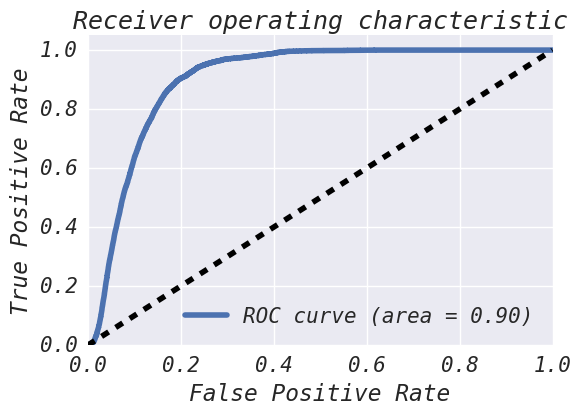

In [4]:
# the classifier we trained in produce_data is actually pretty good
tutorial_helpers.plot_roc(y_test, scores)

In [5]:
# true prevalence of positive examples in the dataset (weighted by importance) 
views[is_spam].sum() / views.sum() * 100.0

1.6483618712920829

### Demonstrate helper functions 

Take a normal random sample that introduces no bias from the scores parameter we see that estimated prevalence roughly matches the true prevalence.

Also note that the percent of positive records sampled (sampled_positive_percent) matches overall prevalence. This shows that we haven't biased our sample towards taking more positive examples.

In [7]:
# This function is very simple, it takes a sample given the parameters specified
# then it computes prevalence and sampled_positive_percent.
tutorial_helpers.sample_stats(
    views, 
    is_spam, 
    np.ones(len(views)), 
    num_samples=3000,  
)

{u'bound_width': 0.86050843646031128,
 u'coverage': True,
 u'est_prevalence': 1.4666666666666668,
 u'lower_bound': 1.0364124484365114,
 u'sampled_positive_percent': 1.4666666666666666,
 u'true_prevalence': 1.6483618712920829,
 u'upper_bound': 1.8969208848968226}

In [8]:
# do the above but many times (4k). 
# This gives us 95% confidence intervals for prevalence of 'is positive' in the population

results = tutorial_helpers.simulated_sample_stats(
    views, 
    is_spam, 
    np.ones(len(views)), 
    num_samples=3000, 
    num_iterations=400
)

In [9]:
results.head()

,bound_width,coverage,est_prevalence,lower_bound,sampled_positive_percent,true_prevalence,upper_bound
0,0.977,True,1.900,1.411,1.900,1.648,2.389
1,0.943,True,1.767,1.295,1.767,1.648,2.238
2,0.800,True,1.267,0.866,1.267,1.648,1.667
3,0.907,True,1.633,1.180,1.633,1.648,2.087
4,1.010,True,2.033,1.528,2.033,1.648,2.538


In [10]:
for c in ['est_prevalence', 'sampled_positive_percent']:
    print '{}:'.format(c)
    tutorial_helpers.print_confidence_interval(results[c].quantile([0.025, 0.5,  0.975]), '\t')
    print
    
print 'Avg. Coverage: {}'.format(results.coverage.mean())
print 'Avg. Confidence Interval Width: {}'.format(results.bound_width.mean())

est_prevalence:
	Value: 1.6333
	95% Confidence Interval: (1.2325, 2.1333)
		CI Width: 0.90083

sampled_positive_percent:
	Value: 1.6333
	95% Confidence Interval: (1.2325, 2.1333)
		CI Width: 0.90083

Avg. Coverage: 0.945
Avg. Confidence Interval Width: 0.908405265306


### Create bias functions 
(To be evaluated below)

In [12]:
# these bins are used for the various bias functions and for plotting
bins = np.linspace(0, 1, 10)

# make some convenience functions for use below
# see bias_functions for information on each method

def pdf_func(scores):
    return ml_sampler.interpolated_pdf_reciprocal(
        scores, 
        bins=bins
    )

def bin_weights_func(scores):
    return ml_sampler.bin_weights_raw(
        scores, 
        bins=bins, 
        # note: we pick extreme weights in order to draw some distinctions below
        #   this weight selection heavily favors higher score bins
        bin_weights=np.logspace(1, 5.0, 10)
    )

# Methods are visualized below
methods = [
    # Normal probability proportionate to size sampling
    ('PPS Sample', lambda score: np.ones(len(score))),    
    
    # Bias the sample to take equal samples from each score bin
    ('Score Frequency', pdf_func), 

    # Use the raw model scores to bias the sample.
    # Things that hive higher scores are proportionately higher to be 
    # samples.
    ('Score Values', lambda score: score),
    
    # Use the raw model scores to bias the sample.
    # Things that hive higher scores are proportionately higher to be 
    # samples.
    ('sqrt(Score Values)', lambda score: np.sqrt(score)),
]

## Plot ROC-AUC and the distribution of scores sampled
Each method produces an unbiased estimate of prevalence even as the model's performance improves. Statements below based on visual inspection of this limited sample. More principled plots found just below this section.

**PPS Sample** - Has the same distribution of scores as in the broader sample.

**Uniform Scores** - Has a flat distribution of scores. A safe default.

**Scores** - Should be biased towards higher score bins but can be influenced by the overall population's distribution.

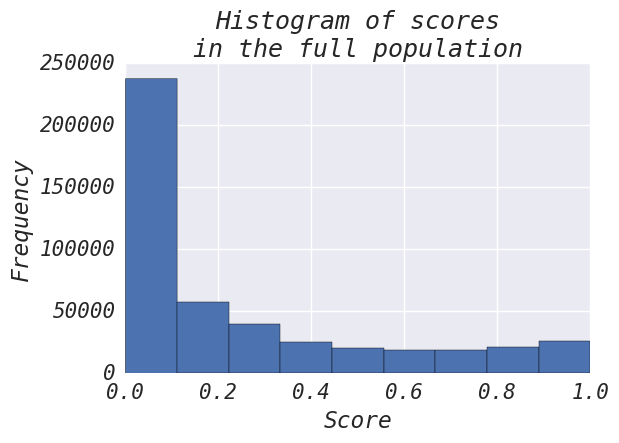

In [13]:
_ = plt.hist(scores, bins=bins)
plt.title('Histogram of scores\nin the full population')
plt.xlabel('Score')
plt.ylabel('Frequency')

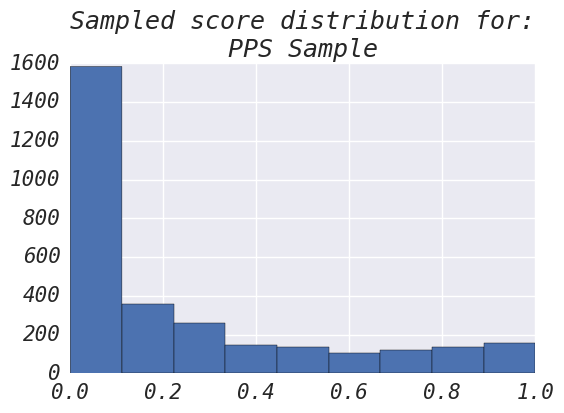

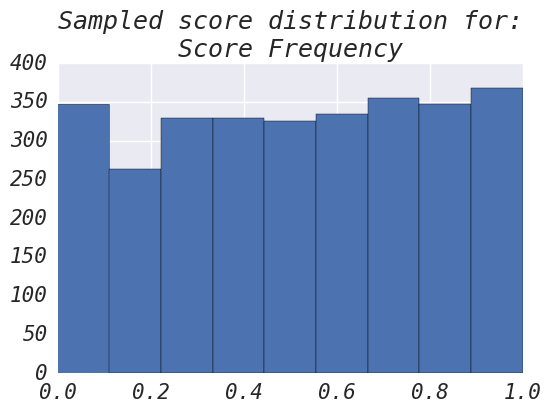

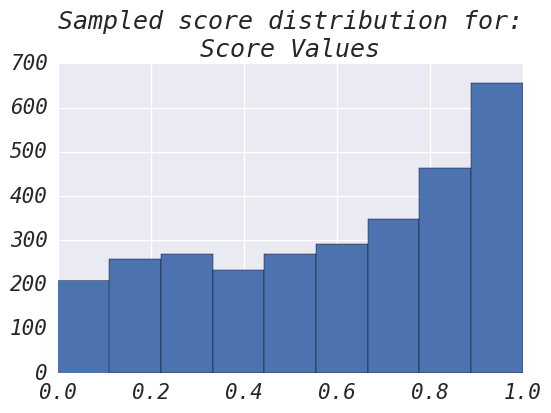

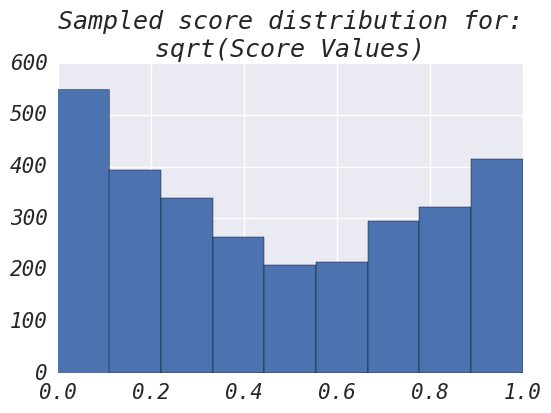

In [14]:
for name, func in methods:
    
    index, weights = ml_sampler.biased_sample(
        biases=func(scores), 
        weights=views, 
        num_samples=3000,
    )
    
    plt.show()
    pd.Series(scores[index]).hist(bins=bins)
    plt.title('Sampled score distribution for:\n'+name)

## Evaluate the various biases in terms of ROC AUC
Investigate how model performance influences the various bias functions.

In [15]:
results = []

for rnd in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    
    # as rnd increases the model performance gets worse
    views, is_spam, scores = produce_data(pcnt_random=rnd)  
    
    auc = tutorial_helpers.get_auc(is_spam, scores) 
    
    for method, func in methods:
        for i in range(7):
            r = tutorial_helpers.sample_stats(views, is_spam, func(scores), num_samples=1000)
            
            r['ROC AUC'] = auc
            # introduce a little jitter to make the plots easier to view
            r['ROC AUC'] += np.random.rand() / 30.
            
            r['method'] = method
            results.append(r)
            
results = pd.DataFrame(results)        

In [16]:
results.head()

,ROC AUC,bound_width,coverage,est_prevalence,lower_bound,method,sampled_positive_percent,true_prevalence,upper_bound
0,0.924,1.736,True,2.000,1.132,PPS Sample,2.000,1.649,2.868
1,0.917,1.778,True,2.100,1.211,PPS Sample,2.100,1.649,2.989
2,0.913,1.508,True,1.500,0.746,PPS Sample,1.500,1.649,2.254
3,0.901,1.974,True,2.600,1.613,PPS Sample,2.600,1.649,3.587
4,0.906,1.693,True,1.900,1.053,PPS Sample,1.900,1.649,2.747


In [17]:
colors = ['orange', 'royalblue', 'grey', 'lightblue', 'purple']

def plot_vs_auc(results, col):
    """Plot various statistics as a function of ROC AUC"""
    ax = None
    i = 0
    for method, func in methods:
        df = results[results.method==method]

        ax = df.plot(
            x='ROC AUC', 
            y=col, 
            kind='scatter', 
            label=method, 
            ax=ax, 
            color=colors[i],
            figsize=(10, 7),
            s=40
        )
        plt.legend(loc='upper left')
        i += 1

### Prevalence estimate vs ROC AUC
Each method produces an unbiased estimate of prevalence even as the model's performance improves. Statements below based on visual inspection of this limited sample. More principled plots found just below this section.

**PPS Sample** - Not impacted by model performance b/c bias is ignored. Tight grouping which suggests relatively low variance.

**Uniform Scores** - Tight grouping which suggests relatively low variance. Variance reduces as model performance improves.

**Scores** - Tight grouping which suggests relatively low variance. Variance reduces as model performance improves.


(0, 3.5)

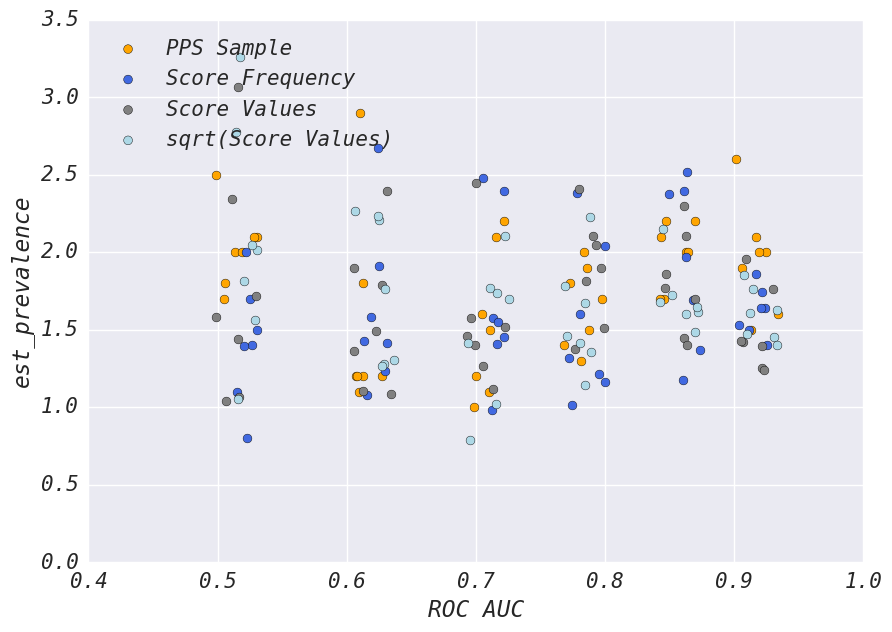

In [18]:
plot_vs_auc(results, 'est_prevalence')
plt.ylim(0, 3.5)
# note jitter was introduced to AUC to make the plots easier to read

### Percent sampled positive vs ROC AUC
Each method produces an unbiased estimate of prevalence even as the model's performance improves. Statements below based on visual inspection of this limited sample. More principled plots found just below this section.

**PPS Sample** - Not impacted by model performance b/c bias is ignored. No improvement in positive examples sampled as model performance improves.

**Uniform Scores** - Moderate improvement in positive examples sampled as model performance improves.

**Scores** - Moderate improvement in positive examples sampled as model performance improves.

(0, 6.5)

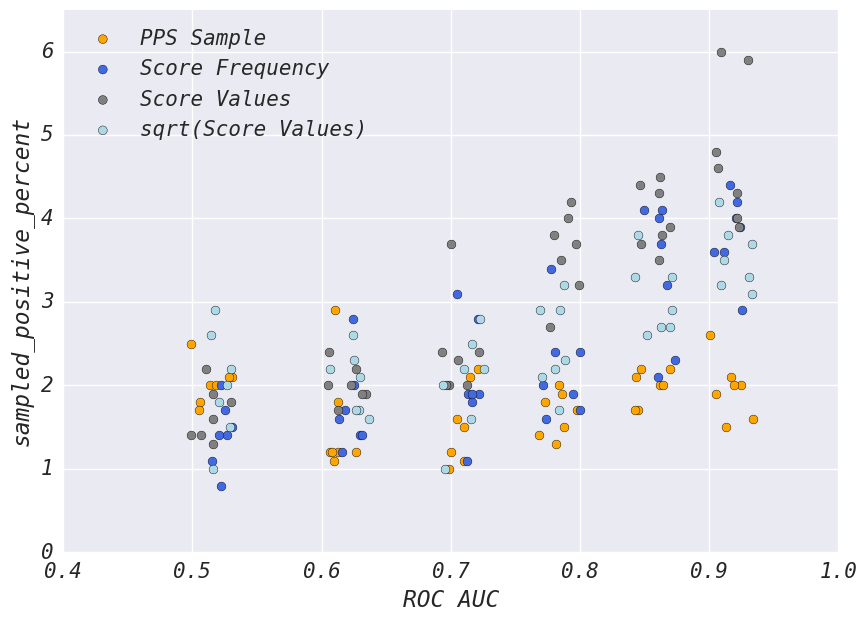

In [19]:
# All methods show increasing number of positive examples sampled as ROC-AUC improves
# for the classifier (except the no bias method)
plot_vs_auc(results, 'sampled_positive_percent')
plt.ylim(0, 6.5)
# note jitter was introduced to AUC to make the plots easier to read

### Use simulations to understand the variance of each bias  function
Looking at the above (small) samples can give intuition for what is going on. Below we do a more through analysis prevalence and sampled_positive_percent with error bars.

In [28]:
simulated_auc_results = []

# this takes a loooooong time
pcnt_rand = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
for rnd in pcnt_rand:
    
    # As rnd increases the model performance gets worse
    views, is_spam, scores = produce_data(pcnt_random=rnd)    
    
    auc = tutorial_helpers.get_auc(is_spam, scores)
    
    i = 1
    for method, func in methods:
        
        simulated_results = tutorial_helpers.simulated_sample_stats(
            views, is_spam, func(scores), num_samples=3000, num_iterations=4000)
        
        simulated_results['AUC'] = auc 
        simulated_results['method'] = method
        
        simulated_auc_results.append(simulated_results)

In [29]:
auc_results = pd.concat(simulated_auc_results)

In [30]:
auc_results.head()

,bound_width,coverage,est_prevalence,lower_bound,sampled_positive_percent,true_prevalence,upper_bound,AUC,method
0,0.811,True,1.300,0.895,1.300,1.672,1.705,0.901,PPS Sample
1,0.831,True,1.367,0.951,1.367,1.672,1.782,0.901,PPS Sample
2,0.851,True,1.433,1.008,1.433,1.672,1.859,0.901,PPS Sample
3,0.969,True,1.867,1.382,1.867,1.672,2.351,0.901,PPS Sample
4,0.934,True,1.733,1.266,1.733,1.672,2.200,0.901,PPS Sample


#### ANALYSIS
**PPS Sample** - Has consistent variance across model improvements.

**Uniform Scores**- Variance reduces and sampled_positive_percent increases as the model improves.

**Scores** - Variance reduces and sampled_positive_percent increases as the model improves.

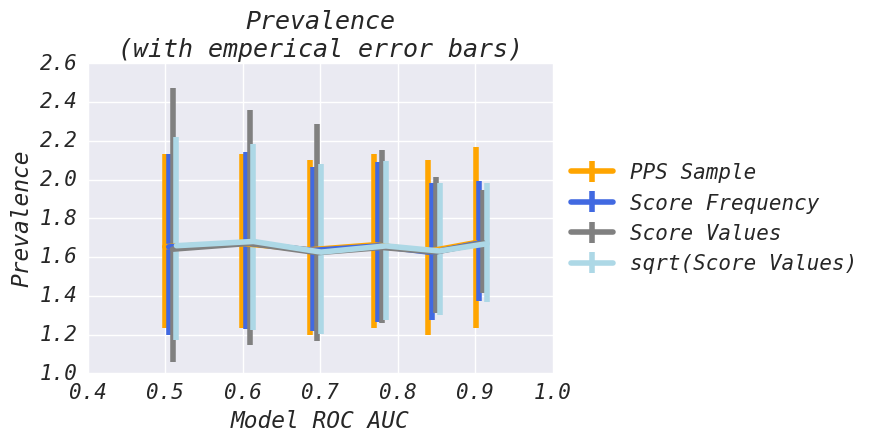

In [31]:

rand_offsets = [x / 200. for x in range(len(methods))]

for i, c in enumerate([tup[0] for tup in methods]):
    data = auc_results[auc_results.method==c].groupby('AUC')

    prevalence = data.est_prevalence.mean().sort_index()    
    low_err = data.est_prevalence.quantile(0.025).sort_index()
    high_err = data.est_prevalence.quantile(0.975).sort_index()
    
    high_err = high_err - prevalence
    low_err = prevalence - low_err


    fig = plt.errorbar(
        prevalence.index + rand_offsets[i], 
        prevalence, 
        yerr=(low_err, high_err), 
        color=colors[i], label=c
    )
    

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Prevalence\n(with emperical error bars)')
plt.ylabel('Prevalence')
plt.xlabel('Model ROC AUC')
plt.show()    

# note jitter was introduced to AUC to make the plots easier to read

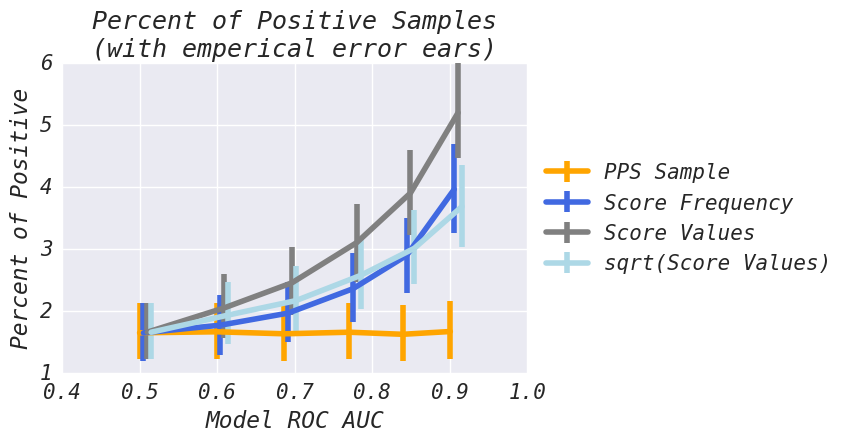

In [32]:

rand_offsets = [x / 200. for x in range(len(methods))]

for i, c in enumerate([tup[0] for tup in methods]):

    data = auc_results[auc_results.method==c].groupby('AUC')
    
    low_err = data.sampled_positive_percent.quantile(0.025).sort_index()
    high_err = data.sampled_positive_percent.quantile(0.975).sort_index()
    prevalence = data.sampled_positive_percent.mean().sort_index()
    
        
    high_err = high_err - prevalence
    low_err = prevalence - low_err
    
    fig = plt.errorbar(
        prevalence.index + rand_offsets[i], 
        prevalence, 
        yerr=(low_err, high_err), 
        color=colors[i], label=c
    )


plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Percent of Positive Samples\n(with emperical error ears)')
plt.ylabel('Percent of Positive')
plt.xlabel('Model ROC AUC')
plt.show()


# note jitter was introduced to AUC to make the plots easier to read

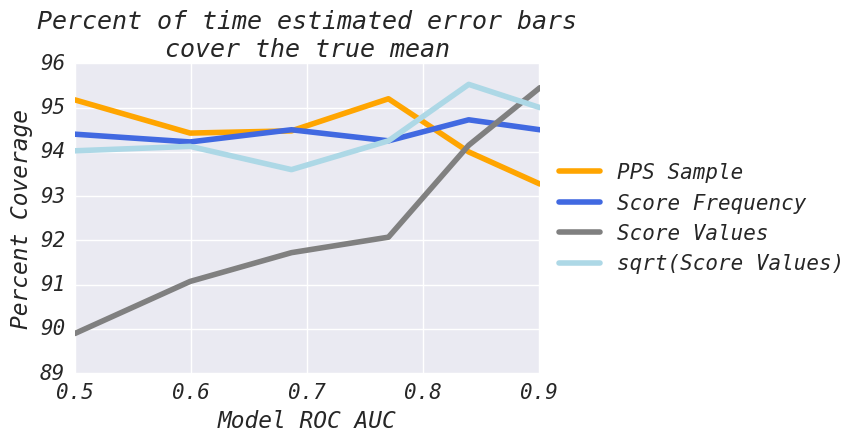

In [33]:
for i, c in enumerate([tup[0] for tup in methods]):
    df = auc_results[auc_results.method == c]
    (df.groupby('AUC').coverage.mean() * 100).plot(label=c, color=colors[i])
    
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Percent of time estimated error bars\ncover the true mean')
plt.ylabel('Percent Coverage')
plt.xlabel('Model ROC AUC')
plt.show()


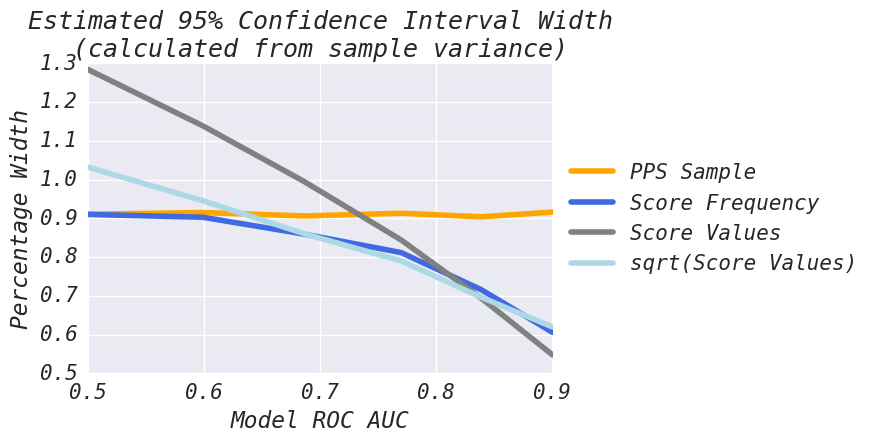

In [34]:
for i, c in enumerate([tup[0] for tup in methods]):
    df = auc_results[auc_results.method == c]
    df.groupby('AUC').bound_width.mean().plot(label=c, color=colors[i])
    
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Estimated 95% Confidence Interval Width\n(calculated from sample variance)')
plt.ylabel('Percentage Width')
plt.xlabel('Model ROC AUC')
plt.show()


## Optimum bin allocation
We can measure the variance in each bin to re-weight our sample to sample more from the bins that have the most variance. This serves to further reduce the variance associated with the sample.

For more information see Optimum Allocation on the Wikipedia entry for Stratified Sampling - https://en.wikipedia.org/wiki/Stratified_sampling#Stratified_sampling_strategies

### Set bin weights to variance for each bin to reduce variance

In [35]:
views, is_spam, scores = produce_data()

In [36]:
# take a sample to get a good number of samples per bin
index, p_sample = ml_sampler.biased_sample(
    
    biases=ml_sampler.interpolated_pdf_reciprocal(scores, bins), 
    weights=views, 
    # take a lot of samples so that we have a good number per bin
    #  the more samples we have per bin the more sure we can be in 
    #  the variance calculation for each bin
    num_samples=20000,
)

In [37]:
# calculate the standard deviation per bin

stdevs = []

for l, h in [(bins[i-1], bins[i]) for i in range(1,len(bins))]:
    sel = scores[index] >= l
    sel &= scores[index] - 0.000001 < h
    
    est_var = ml_sampler.estimated_variance(views[index[sel]], p_sample[sel], is_spam[index[sel]]) 
    
    stdevs.append(np.sqrt(est_var))
    
stdevs = np.array(stdevs)
stdevs += stdevs.sum()/100.

In [38]:
# use the stdevs as bin weights, this means we sample more from bins with higher stdevs
def variance_reducing_func(scores): 
    return ml_sampler.bin_weights_corrected(scores, bins, stdevs) 

opt_index, opt_weights = ml_sampler.biased_sample(
    biases=variance_reducing_func(scores),
    weights=views,     
    num_samples=3000,
)

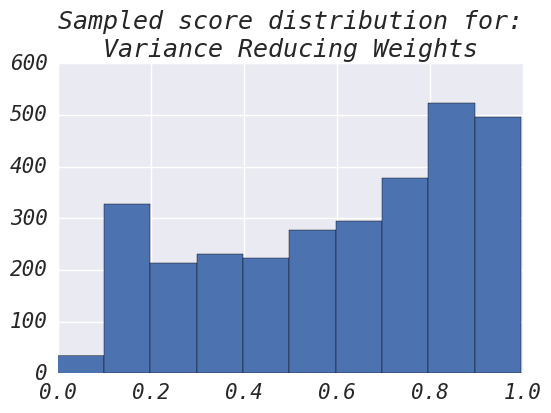

In [39]:
pd.Series(scores[opt_index]).hist()
plt.title('Sampled score distribution for:\nVariance Reducing Weights')

### Estimate the 95% confidence intervals for each method
For comparison with the optimum bin allocation method below.

In [44]:
simulated_results = []

# takes a bit
for name, func in methods + [("'Optimum Allocation'", variance_reducing_func)]:
    # This function produces simulated confidence interval estimates for
    #  the prevalence of positive examples in our population. This measures
    #  the accuracy & precision of each method. Ideally we should have 
    #  values that match the overall population percentage 
    res = tutorial_helpers.simulated_sample_stats(views, is_spam, func(scores), 1000)
    
    simulated_results.append((name, res))

In [46]:
result.head()

,bound_width,coverage,est_prevalence,lower_bound,sampled_positive_percent,true_prevalence,upper_bound
0,1.693,True,1.900,1.053,1.900,1.647,2.747
1,1.405,True,1.300,0.598,1.300,1.647,2.002
2,1.508,True,1.500,0.746,1.500,1.647,2.254
3,1.556,True,1.600,0.822,1.600,1.647,2.378
4,1.457,True,1.400,0.671,1.400,1.647,2.129


In [48]:
for method, result in simulated_results:
    print '{}:'.format(method)
    print '\tprevalence:'
    tutorial_helpers.print_confidence_interval(result.est_prevalence.quantile([0.025, 0.5, 0.975]), '\t\t')
    print 
        

PPS Sample:
	prevalence:
		Value: 1.6000
		95% Confidence Interval: (0.9000, 2.5000)
			CI Width: 1.60000

Score Frequency:
	prevalence:
		Value: 1.6379
		95% Confidence Interval: (1.1594, 2.2033)
			CI Width: 1.04388

Score Values:
	prevalence:
		Value: 1.6402
		95% Confidence Interval: (1.2022, 2.1262)
			CI Width: 0.92395

sqrt(Score Values):
	prevalence:
		Value: 1.6458
		95% Confidence Interval: (1.1315, 2.2020)
			CI Width: 1.07058

'Optimum Allocation':
	prevalence:
		Value: 1.6360
		95% Confidence Interval: (1.2129, 2.1147)
			CI Width: 0.90179



### Analysis
In this situation both Optimum Allocation and the Score methods give good results. Theoretically, Optimum Allocation produces the best results - it is highly dependent on the quality of the initial sample. A bad initial sample can produce results that are slightly worse than Score Adjusted but typically still better than the other methods. 